In [1]:
#Import Necessary Libraries :-
from os import listdir
import os
from pickle import dump, load
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Extract Image Features

In [ ]:
# Import InceptionV3 and Use second-to-last layer for feature extraction :-
base_model = InceptionV3(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)  

# summarize :-
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [3]:
# extract features from each photo in the directory :-
def extract_features(directory):
	# extract features from each photo :-
	features = dict()
	i=0
	for name in listdir(directory):

		# load an image from file :-
		filename = directory + '/' + name
		image = load_img(filename, target_size=(299, 299))

		# convert the image pixels to a numpy array :-
		image = img_to_array(image)

		# reshape data for the model :-
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

		# prepare the image for the InceptionV3 model :-
		image = preprocess_input(image)

		# get features :-
		feature = model.predict(image, verbose=0)

		# get image id :-
		image_id = name.split('.')[0]

		# store feature :-
		features[image_id] = feature
		i=i+1
		if i%50 == 0 : 
			print(i)
        
	return features

# directory of image :-
directory = 'Images'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))

# save to file :-
dump(features, open('features.pkl', 'wb'))

In [4]:
with open('features.pkl', 'rb') as f:
    features = load(f)

In [5]:
features

{'1000268201_693b08cb0e': array([[0.12277643, 0.3329312 , 0.7527252 , ..., 0.21941511, 0.30208507,
         0.4027956 ]], dtype=float32),
 '1001773457_577c3a7d70': array([[0.7366835 , 0.59113204, 0.18194184, ..., 0.16030239, 0.3414471 ,
         0.908316  ]], dtype=float32),
 '1002674143_1b742ab4b8': array([[0.37349236, 0.24600627, 0.96336496, ..., 1.1460398 , 0.26551482,
         0.01984677]], dtype=float32),
 '1003163366_44323f5815': array([[0.48604363, 0.2921787 , 0.31434867, ..., 0.9825368 , 0.2810951 ,
         0.22330494]], dtype=float32),
 '1007129816_e794419615': array([[0.21595934, 0.15582606, 0.29477608, ..., 0.40562937, 0.1653241 ,
         0.37413383]], dtype=float32),
 '1007320043_627395c3d8': array([[0.17230761, 0.49810615, 0.21577124, ..., 0.09679499, 1.2298672 ,
         0.5421525 ]], dtype=float32),
 '1009434119_febe49276a': array([[0.53430784, 1.3675826 , 0.78057486, ..., 0.39465463, 0.8875857 ,
         1.0727918 ]], dtype=float32),
 '1012212859_01547e3f17': array([[

# Load the Captions Data

In [6]:
capDir = 'C:/Users/asus/Desktop/Img Caption Generator/captions'
with open(os.path.join(capDir, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
# create mapping of image to captions :-
mapping = {}

for line in tqdm(captions_doc.split('\n')):

    # split image id and caption by comma(,) :-
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]

    # remove extension from image ID :-
    image_id = image_id.split('.')[0]

    # convert caption list to string :-
    caption = " ".join(caption)

    # create list if needed :-
    if image_id not in mapping:
        mapping[image_id] = []
        
    # store the caption :-
    mapping[image_id].append(caption)
    
len(mapping)

  0%|          | 0/40456 [00:00<?, ?it/s]

8091

In [8]:
mapping

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

# Preprocess Text Data

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):

            # take one caption at a time :-
            caption = captions[i]
            
            # preprocessing steps and convert to lowercase :-
            caption = caption.lower()

            # preprocessing steps :-
            caption = '<start> ' + " ".join([word for word in caption.split() if len(word)>0]) + ' <end>'
            captions[i] = caption

In [10]:
clean(mapping)
mapping

{'1000268201_693b08cb0e': ['<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
  '<start> a girl going into a wooden building . <end>',
  '<start> a little girl climbing into a wooden playhouse . <end>',
  '<start> a little girl climbing the stairs to her playhouse . <end>',
  '<start> a little girl in a pink dress going into a wooden cabin . <end>'],
 '1001773457_577c3a7d70': ['<start> a black dog and a spotted dog are fighting <end>',
  '<start> a black dog and a tri-colored dog playing with each other on the road . <end>',
  '<start> a black dog and a white dog with brown spots are staring at each other in the street . <end>',
  '<start> two dogs of different breeds looking at each other on the road . <end>',
  '<start> two dogs on pavement moving toward each other . <end>'],
 '1002674143_1b742ab4b8': ['<start> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . <end>',
  '<start> a little girl is sitting

In [11]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

len(all_captions)

40455

In [12]:
# tokenize the text :-
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

vocab_size

9182

In [13]:
# get maximum length of the caption available :-
max_length = max(len(caption.split()) for caption in all_captions)
max_length

39

# Train Test Split

In [14]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
print(split)
train = image_ids[:split]
test = image_ids[split:]

7281


In [15]:
# create data generator to get data in batch (avoids session crash) :-
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):

    # loop over images :-
    X1, X2, y = list(), list(), list()
    n = 0

    # infinite loop :-
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]

            # process each caption :-
            for caption in captions:

                # encode the sequence :-
                seq = tokenizer.texts_to_sequences([caption])[0]

                # split the sequence into X, y pairs :-
                for i in range(1, len(seq)):

                    # split into input and output pairs :-
                    in_seq, out_seq = seq[:i], seq[i]

                    # pad input sequence (so that it has common len) :-
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]

                    # encode output sequence (like OHE) :-
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]

                    # store the sequences :-
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

In [16]:
# encoder model :-

# image feature layers
inputs1 = Input(shape=(2048,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


# decoder model :-
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None, 39)]                 0         []                            
                                                                                                  
 image (InputLayer)          [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 39, 256)              2350592   ['text[0][0]']                
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['image[0][0]']               
                                                                                            

In [18]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):

    # create data generator :-
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    # fit for one epoch :-
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 817s 4s/step - loss: 1.9275


In [19]:
import os

directory = r'C:/Users/asus/Desktop/Img Caption Generator'
if not os.path.exists(directory):
    os.makedirs(directory)

model.save(os.path.join(directory, 'best_model.h5'))


c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Generate Captions for the Image

In [20]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate caption for an image :-
def predict_caption(model, image, tokenizer, max_length):

    # add start tag for generation process :-
    in_text = '<start> '

    # iterate over the max length of sequence :-
    for i in range(max_length):

        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        # pad the sequence :-
        sequence = pad_sequences([sequence], max_length, padding='post')

        # predict next word :-
        yhat = model.predict([image, sequence], verbose=0)

        # get index with high probability :-
        yhat = np.argmax(yhat)

        # convert index to word :-
        word = idx_to_word(yhat, tokenizer)

        # stop if word not found :-
        if word is None:
            break

        # append word as input for generating next word :-
        in_text += " " + word

        # stop if we reach end tag :-
        if word == '<end>':
            break
        
    return in_text

In [21]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data :-
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption :-
    captions = mapping[key]

    # predict the caption for image :-
    y_pred = predict_caption(model, features[key], tokenizer, max_length)

    # split into words :-
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    # append to the list :-
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score :-
print(f"BLEU-1:  {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}")
print(f"BLEU-2:  {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}")

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1:  0.6048109965635738
BLEU-2:  0.4367227358858313


# Visualize the Results

In [22]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image :-
    image_id = image_name.split('.')[0]
    img_path = os.path.join(directory, "Images", image_name)
    image = Image.open(img_path)

    # Actual caption :-
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # Predicted caption :-
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [36]:
test

['436015762_8d0bae90c3',
 '436393371_822ee70952',
 '436608339_f1d1298770',
 '437054333_5c2761b8cd',
 '437404867_209625774d',
 '437527058_189f2a7eef',
 '437917001_ae1106f34e',
 '438639005_208bc59b0b',
 '439037721_cdf1fc7358',
 '439049388_3dcee2d30b',
 '439492931_a96d590e40',
 '439569646_c917f1bc78',
 '439916996_1ddb9dc8e7',
 '440184957_267f3f3a2b',
 '440190907_bf8b7ba8ef',
 '440737340_5af34ca9cf',
 '441212506_fcc321ac28',
 '44129946_9eeb385d77',
 '441398149_297146e38d',
 '441817653_fbdf83060b',
 '441921713_1cafc7d7d2',
 '442220883_ff3d6e507f',
 '442594271_2c3dd38483',
 '442918418_0f29c97fa9',
 '443430496_3fea95a07d',
 '443885436_6e927e6c58',
 '444047125_66b249287c',
 '444057017_f1e0fcaef7',
 '444481722_690d0cadcf',
 '444803340_fdcaab86f9',
 '444845904_a4531c811a',
 '444872454_9f51e07f88',
 '444881000_bba92e585c',
 '445148321_9f2f3ac711',
 '445655284_c29e6d7323',
 '445861800_75fc6a8c16',
 '446138054_d40c66d5f0',
 '446286714_dcec7f339e',
 '446291803_2fd4641b99',
 '446514680_ff5ca15ece',
 

---------------------Actual---------------------
<start> a black dog and a spotted dog are fighting <end>
<start> a black dog and a tri-colored dog playing with each other on the road . <end>
<start> a black dog and a white dog with brown spots are staring at each other in the street . <end>
<start> two dogs of different breeds looking at each other on the road . <end>
<start> two dogs on pavement moving toward each other . <end>
--------------------Predicted--------------------
<start>  two dogs are playing with each other on the grass . <end>


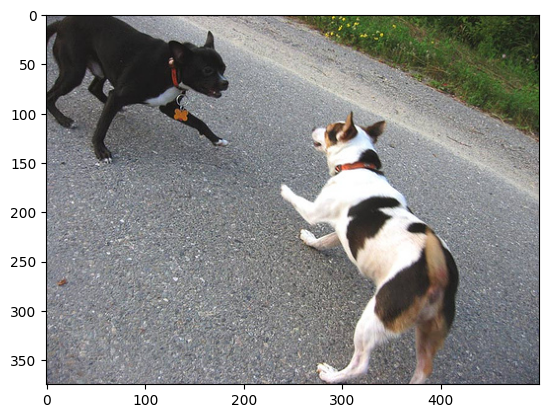

In [23]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
<start> brown dogs and a woman in a yard <end>
<start> a brown dog persues a frisbee across the grass as the thrower watches . <end>
<start> a woman in a blue jacket watches as her two brown dogs play with a red ball in a grassy yard . <end>
<start> a woman throws a frisbee for her two brown dogs to chase . <end>
<start> a woman watches a brown dog run away from a house across the grass . <end>
--------------------Predicted--------------------
<start>  a dog lies on its hind legs reaching to catch a ball . <end>


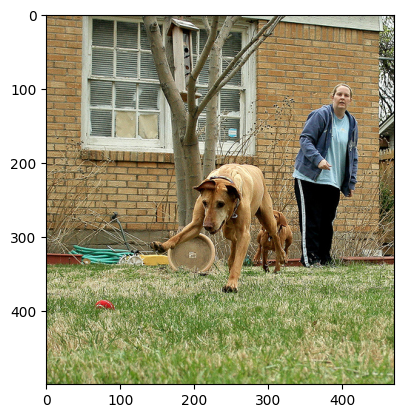

In [24]:
generate_caption("439916996_1ddb9dc8e7.jpg")

---------------------Actual---------------------
<start> a girl in a pool wearing goggles and surrounded by other children <end>
<start> a girl in green goggles in a pool with three other children . <end>
<start> a red haired girl making a peace sign is wearing neon green glasses and floaties and playing in the pool with other kids . <end>
<start> a red-headed girl offers the peace sign as she swims in the pool with floaties . <end>
<start> a young girl with goggles and floaties poses for the camera as she plays in a pool . <end>
--------------------Predicted--------------------
<start>  a boy in a swimming pool . <end>


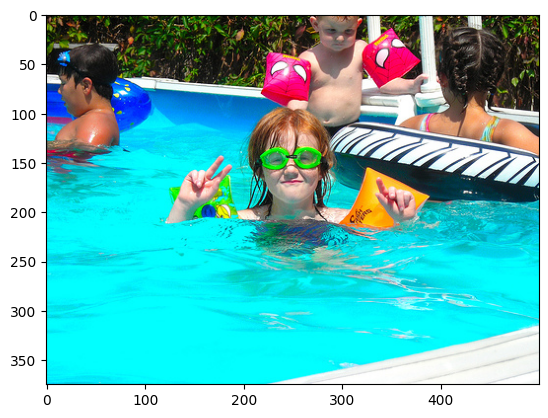

In [25]:
generate_caption("989754491_7e53fb4586.jpg")

---------------------Actual---------------------
<start> a brown dog and a black dog run into each other in the grass . <end>
<start> a brown dog is grabbing the collar of a black dog . <end>
<start> a dark black dog is playing with a light brown dog in a backyard . <end>
<start> two dogs are wrestling in a field . <end>
<start> two dogs are wrestling in the park . <end>
--------------------Predicted--------------------
<start>  two dogs are running on leashes . <end>


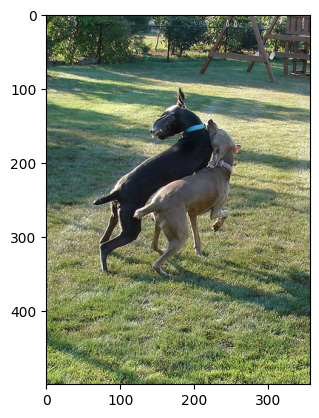

In [26]:
generate_caption("957682378_46c3b07bcd.jpg")

---------------------Actual---------------------
<start> two children are on a giant inflatable slide . <end>
<start> two children holding hands going down a large inflatable slide . <end>
<start> two girls slide down the air-filled slide . <end>
<start> two kids slide down a giant inflatable slide . <end>
<start> two little girls slide down an inflated slide . <end>
--------------------Predicted--------------------
<start>  a little boy is sitting on a red slide in a park . <end>


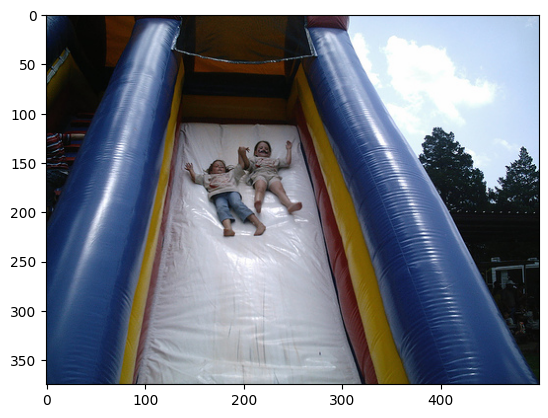

In [27]:
generate_caption("537758332_8beb9cf522.jpg")